In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

In [4]:
import leveldiagram as ld

## Basic 3-level diagrams ##

In [5]:
lambda_nodes = ((0),
                (1),
                (2, {'energy':-0.1}))
lambda_edges = ((0,1,{'detuning':0.1, 'label':'probe'}),
                (2,1,{'label':'couple', 'lw':4, 'arrowsize':0.2}))
lambda_graph = nx.DiGraph()
lambda_graph.add_nodes_from(lambda_nodes)
lambda_graph.add_edges_from(lambda_edges)

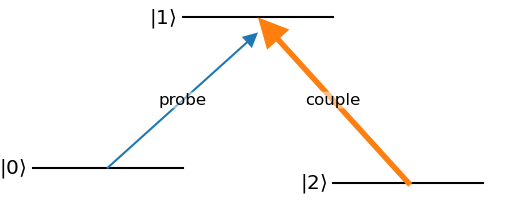

In [6]:
d = ld.LD(lambda_graph)
d.draw()

In [7]:
ladder_nodes = (0,1,2)
ladder_edges = ((0,1,{'label':'probe'}),
                (1,2,{'label':'couple'}))
ladder_graph = nx.DiGraph()
ladder_graph.add_nodes_from(ladder_nodes)
ladder_graph.add_edges_from(ladder_edges)

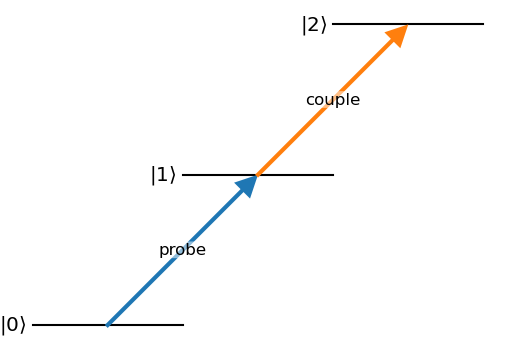

In [8]:
d = ld.LD(ladder_graph,
          coupling_defaults = {'arrowsize':0.15,'lw':3})
d.draw()

In [9]:
v_nodes = ((0),
           (1,{'energy':1,'xpos':-1}),
           (2,{'energy':1, 'xpos':1}))
v_edges = ((0,1,{'label':'probe'}),
           (0,2,{'label':'couple'}))
v_graph = nx.DiGraph()
v_graph.add_nodes_from(v_nodes)
v_graph.add_edges_from(v_edges)

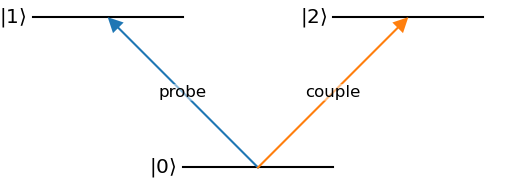

In [10]:
d = ld.LD(v_graph)
d.draw()

## Hyperfine Diagram ##

In [11]:
hf_nodes =  [((f,i), {('top' if f==2 else 'bottom') + '_text':'$m_F='+f'{i:d}'+'$',
                      'energy':f-1,
                      'xpos':i,
                      'width':0.75,
                      'text_kw':{'fontsize':'large'}})
             for f in [1,2]
             for i in range(-f,f+1)]
lin_couples = [((1,i),(2,i),{'label':l,'color':'C0',
                            'label_kw':{'fontsize':'medium','color':'C0'}})
               for i,l in zip(range(-1,2), ['1/2','2/3','1/2'])]
sp_couples = [((1,i),(2,i+1),{'label':l,'color':'C1',
                              'label_offset':'right',
                             'label_kw':{'fontsize':'medium','color':'C1'}})
              for i,l in zip(range(-1,2), ['1/6','1/2','1'])]
sm_couples = [((1,i),(2,i-1),{'label':l, 'color':'C2',
                              'label_offset':'left',
                             'label_kw':{'fontsize':'medium','color':'C2'}})
              for i,l in zip(range(-1,2), ['1','1/2','1/6'])]
hf_edges = lin_couples + sp_couples + sm_couples
hf_graph = nx.DiGraph()
hf_graph.add_nodes_from(hf_nodes)
hf_graph.add_edges_from(hf_edges)

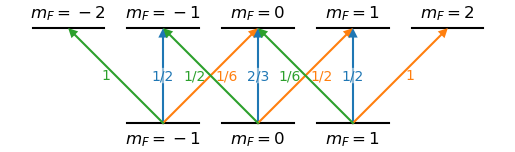

In [12]:
d = ld.LD(hf_graph, default_label = 'none')
d.ax.margins(y=0.2)
d.draw()

## 4-wave Mixing Diagram ##

In [13]:
fwm_nodes = ((0),
             (1,{'xpos':-1}),
             (2,{'xpos':1,'energy':1}),
             (3,{'energy':2,'xpos':0}))
fwm_edges = ((0,1),
             (1,3),
             (3,2),
             (2,0,{'label':'idler', 'wavy':True}))
fwm_graph = nx.DiGraph()
fwm_graph.add_nodes_from(fwm_nodes)
fwm_graph.add_edges_from(fwm_edges)

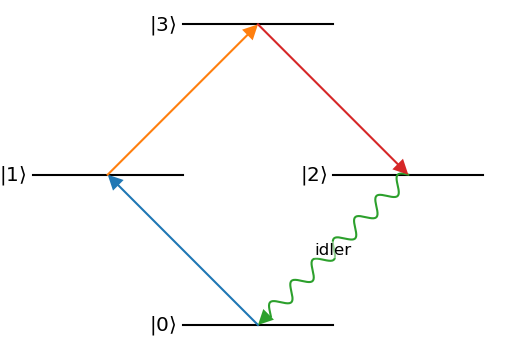

In [14]:
d = ld.LD(fwm_graph)
d.draw()